Deep Learning
=============

Assignment 5
------------

The goal of this assignment is to train a Word2Vec skip-gram model over [Text8](http://mattmahoney.net/dc/textdata) data.

In [27]:
# These are all the modules we'll be using later. Make sure you can import them
# before proceeding further.
%matplotlib inline
from __future__ import print_function
import collections
import math
import numpy as np
import os
import random
import tensorflow as tf
import zipfile
from matplotlib import pylab
from six.moves import range
from six.moves.urllib.request import urlretrieve
from sklearn.manifold import TSNE

Download the data from the source website if necessary.

In [28]:
url = 'http://mattmahoney.net/dc/'

def maybe_download(filename, expected_bytes):
  """Download a file if not present, and make sure it's the right size."""
  if not os.path.exists(filename):
    filename, _ = urlretrieve(url + filename, filename)
  statinfo = os.stat(filename)
  if statinfo.st_size == expected_bytes:
    print('Found and verified %s' % filename)
  else:
    print(statinfo.st_size)
    raise Exception(
      'Failed to verify ' + filename + '. Can you get to it with a browser?')
  return filename

filename = maybe_download('text8.zip', 31344016)

Found and verified text8.zip


Read the data into a string.

In [29]:
def read_data(filename):
  """Extract the first file enclosed in a zip file as a list of words"""
  with zipfile.ZipFile(filename) as f:
    data = tf.compat.as_str(f.read(f.namelist()[0])).split()
  return data
  
words = read_data(filename)
print('Data size %d' % len(words))

Data size 17005207


Build the dictionary and replace rare words with UNK token.

In [30]:
vocabulary_size = 50000

def build_dataset(words):
  count = [['UNK', -1]]
  count.extend(collections.Counter(words).most_common(vocabulary_size - 1))
  dictionary = dict()
  for word, _ in count:
    dictionary[word] = len(dictionary)
  data = list()
  unk_count = 0
  for word in words:
    if word in dictionary:
      index = dictionary[word]
    else:
      index = 0  # dictionary['UNK']
      unk_count = unk_count + 1
    data.append(index)
  count[0][1] = unk_count
  reverse_dictionary = dict(zip(dictionary.values(), dictionary.keys())) 
  return data, count, dictionary, reverse_dictionary

data, count, dictionary, reverse_dictionary = build_dataset(words)
print('Most common words (+UNK)', count[:5])
print('Sample data', data[:10])
del words  # Hint to reduce memory.

Most common words (+UNK) [['UNK', 418391], ('the', 1061396), ('of', 593677), ('and', 416629), ('one', 411764)]
Sample data [5234, 3081, 12, 6, 195, 2, 3134, 46, 59, 156]


- `words`: array of full word text `['Nice', 'to', 'meet', 'you', 'My', 'name', 'is', ...]`
- `count`: array of couple which contains word text and its total count `[['the', 5032], ['a', 3421], ['an', 932], ...]`
- `dictionary`: map of words to index `{'the': 1, 'hi': 52, 'yes': 53, 'there': 64, ...}`
- `reverse_dictionary`: map of `{1: 'the', 52: 'hi', 53: 'yes', 64: 'there', ...}`
- `data`: array of full word index `[322, 42, 10, 52, 22, 31, ...]`

Function to generate a training batch for the skip-gram model.

In [7]:
data_index = 0

def generate_batch(batch_size, num_skips, skip_window):
  global data_index
  assert batch_size % num_skips == 0
  assert num_skips <= 2 * skip_window
  batch = np.ndarray(shape=(batch_size), dtype=np.int32)
  labels = np.ndarray(shape=(batch_size, 1), dtype=np.int32)
  span = 2 * skip_window + 1 # [ skip_window target skip_window ]
  buffer = collections.deque(maxlen=span)
  for _ in range(span):
    buffer.append(data[data_index])
    data_index = (data_index + 1) % len(data)
  for i in range(batch_size // num_skips):
    target = skip_window  # target label at the center of the buffer
    targets_to_avoid = [ skip_window ]
    for j in range(num_skips):
      while target in targets_to_avoid:
        target = random.randint(0, span - 1)
      targets_to_avoid.append(target)
      batch[i * num_skips + j] = buffer[skip_window]
      labels[i * num_skips + j, 0] = buffer[target]
    buffer.append(data[data_index])
    data_index = (data_index + 1) % len(data)
  return batch, labels

print('data:', [reverse_dictionary[di] for di in data[:8]])

for num_skips, skip_window in [(2, 1), (4, 2)]:
    data_index = 0
    batch, labels = generate_batch(batch_size=8, num_skips=num_skips, skip_window=skip_window)
    print('\nwith num_skips = %d and skip_window = %d:' % (num_skips, skip_window))
    print('    batch:', [reverse_dictionary[bi] for bi in batch])
    print('    labels:', [reverse_dictionary[li] for li in labels.reshape(8)])

data: ['anarchism', 'originated', 'as', 'a', 'term', 'of', 'abuse', 'first']

with num_skips = 2 and skip_window = 1:
    batch: ['originated', 'originated', 'as', 'as', 'a', 'a', 'term', 'term']
    labels: ['as', 'anarchism', 'originated', 'a', 'as', 'term', 'of', 'a']

with num_skips = 4 and skip_window = 2:
    batch: ['as', 'as', 'as', 'as', 'a', 'a', 'a', 'a']
    labels: ['originated', 'term', 'a', 'anarchism', 'term', 'originated', 'of', 'as']


Train a skip-gram model.

In [8]:
batch_size = 128
embedding_size = 128 # Dimension of the embedding vector.
skip_window = 1 # How many words to consider left and right.
num_skips = 2 # How many times to reuse an input to generate a label.
# We pick a random validation set to sample nearest neighbors. here we limit the
# validation samples to the words that have a low numeric ID, which by
# construction are also the most frequent. 
valid_size = 16 # Random set of words to evaluate similarity on.
valid_window = 100 # Only pick dev samples in the head of the distribution.
valid_examples = np.array(random.sample(range(valid_window), valid_size))
num_sampled = 64 # Number of negative examples to sample.

graph = tf.Graph()

with graph.as_default(), tf.device('/cpu:0'):

  # Input data.
  train_dataset = tf.placeholder(tf.int32, shape=[batch_size])
  train_labels = tf.placeholder(tf.int32, shape=[batch_size, 1])
  valid_dataset = tf.constant(valid_examples, dtype=tf.int32)
  
  # Variables.
  embeddings = tf.Variable(
    tf.random_uniform([vocabulary_size, embedding_size], -1.0, 1.0))
  softmax_weights = tf.Variable(
    tf.truncated_normal([vocabulary_size, embedding_size],
                         stddev=1.0 / math.sqrt(embedding_size)))
  softmax_biases = tf.Variable(tf.zeros([vocabulary_size]))
  
  # Model.
  # Look up embeddings for inputs.
  embed = tf.nn.embedding_lookup(embeddings, train_dataset)
  # Compute the softmax loss, using a sample of the negative labels each time.
  loss = tf.reduce_mean(
    tf.nn.sampled_softmax_loss(weights=softmax_weights, biases=softmax_biases, inputs=embed,
                               labels=train_labels, num_sampled=num_sampled, num_classes=vocabulary_size))

  # Optimizer.
  # Note: The optimizer will optimize the softmax_weights AND the embeddings.
  # This is because the embeddings are defined as a variable quantity and the
  # optimizer's `minimize` method will by default modify all variable quantities 
  # that contribute to the tensor it is passed.
  # See docs on `tf.train.Optimizer.minimize()` for more details.
  optimizer = tf.train.AdagradOptimizer(1.0).minimize(loss)
  
  # Compute the similarity between minibatch examples and all embeddings.
  # We use the cosine distance:
  norm = tf.sqrt(tf.reduce_sum(tf.square(embeddings), 1, keep_dims=True))
  normalized_embeddings = embeddings / norm
  valid_embeddings = tf.nn.embedding_lookup(
    normalized_embeddings, valid_dataset)
  similarity = tf.matmul(valid_embeddings, tf.transpose(normalized_embeddings))

In [11]:
num_steps = 100001

with tf.Session(graph=graph) as session:
  tf.global_variables_initializer().run()
  print('Initialized')
  average_loss = 0
  for step in range(num_steps):
    batch_data, batch_labels = generate_batch(
      batch_size, num_skips, skip_window)
    feed_dict = {train_dataset : batch_data, train_labels : batch_labels}
    _, l = session.run([optimizer, loss], feed_dict=feed_dict)
    average_loss += l
    if step % 2000 == 0:
      if step > 0:
        average_loss = average_loss / 2000
      # The average loss is an estimate of the loss over the last 2000 batches.
      print('Average loss at step %d: %f' % (step, average_loss))
      average_loss = 0
    # note that this is expensive (~20% slowdown if computed every 500 steps)
    if step % 10000 == 0:
      sim = similarity.eval()
      for i in range(valid_size):
        valid_word = reverse_dictionary[valid_examples[i]]
        top_k = 8 # number of nearest neighbors
        nearest = (-sim[i, :]).argsort()[1:top_k+1]
        log = 'Nearest to %s:' % valid_word
        for k in range(top_k):
          close_word = reverse_dictionary[nearest[k]]
          log = '%s %s,' % (log, close_word)
        print(log)
  final_embeddings = normalized_embeddings.eval()

Initialized
Average loss at step 0: 8.478539
Nearest to four: dementia, nei, kabila, pit, lla, biotic, nir, decibels,
Nearest to that: greenpeace, yoakum, midnight, sumo, g, dendritic, klaproth, venomous,
Nearest to state: machina, neurath, lorenz, smarter, aggravated, sbs, cataracts, commutativity,
Nearest to so: ascertaining, stative, arlo, mandates, scratch, cast, lemons, jeffrey,
Nearest to will: fugitives, wladislaus, extinguish, ante, nunnery, miscarriage, poly, pillow,
Nearest to from: kapoor, fromm, eridu, liga, tradition, our, porter, homeless,
Nearest to system: officially, resounding, valens, intimate, convey, paralleling, vocabulary, presbyterian,
Nearest to three: favored, deliberative, writes, aspectual, incomplete, incubus, facto, disclosure,
Nearest to american: lehigh, deciphering, vesicles, cordless, exploration, fortunes, pauli, clin,
Nearest to be: tattooed, imaging, archeologist, hittite, tipper, raphael, redman, daimler,
Nearest to however: barb, mounting, mcvie, 

Average loss at step 52000: 3.453551
Average loss at step 54000: 3.431222
Average loss at step 56000: 3.402843
Average loss at step 58000: 3.280984
Average loss at step 60000: 3.380081
Nearest to four: seven, five, six, eight, three, two, nine, one,
Nearest to that: which, what, however, this, why, venerable, who, organically,
Nearest to state: government, states, slams, machina, federal, brine, methodist, printing,
Nearest to so: if, conscripted, blockbuster, bulldog, hernando, shit, how, corsica,
Nearest to will: would, can, could, must, may, should, might, cannot,
Nearest to from: through, into, in, across, including, christianum, by, during,
Nearest to system: systems, format, runoff, reds, quotas, bombers, resounding, qing,
Nearest to three: five, four, six, eight, two, seven, nine, one,
Nearest to american: italian, english, french, british, german, irish, independent, tarantino,
Nearest to be: become, been, have, refer, is, avoid, are, were,
Nearest to however: but, although, wh

In [12]:
num_points = 400

tsne = TSNE(perplexity=30, n_components=2, init='pca', n_iter=5000, method='exact')
two_d_embeddings = tsne.fit_transform(final_embeddings[1:num_points+1, :])

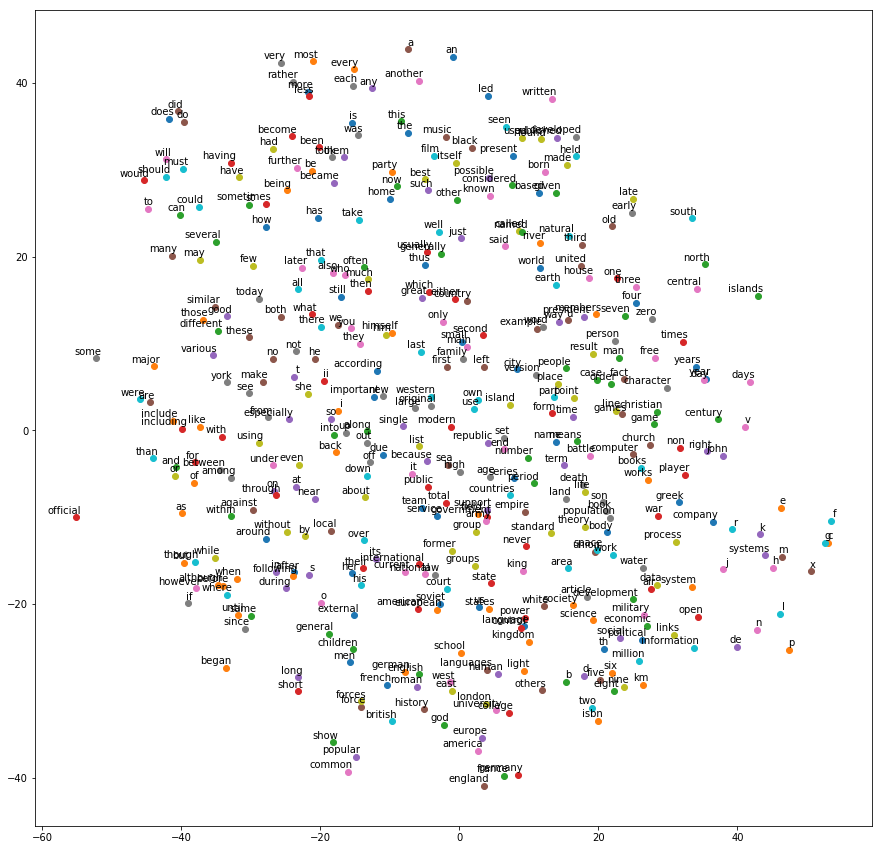

In [13]:
def plot(embeddings, labels):
  assert embeddings.shape[0] >= len(labels), 'More labels than embeddings'
  pylab.figure(figsize=(15,15))  # in inches
  for i, label in enumerate(labels):
    x, y = embeddings[i,:]
    pylab.scatter(x, y)
    pylab.annotate(label, xy=(x, y), xytext=(5, 2), textcoords='offset points',
                   ha='right', va='bottom')
  pylab.show()

words = [reverse_dictionary[i] for i in range(1, num_points+1)]
plot(two_d_embeddings, words)

---

Problem
-------

An alternative to skip-gram is another Word2Vec model called [CBOW](http://arxiv.org/abs/1301.3781) (Continuous Bag of Words). In the CBOW model, instead of predicting a context word from a word vector, you predict a word from the sum of all the word vectors in its context. Implement and evaluate a CBOW model trained on the text8 dataset.

---

In [33]:
# These are all the modules we'll be using later. Make sure you can import them
# before proceeding further.
%matplotlib inline
from __future__ import print_function
import collections
import math
import numpy as np
import os
import random
import tensorflow as tf
import zipfile
from matplotlib import pylab
from six.moves import range
from six.moves.urllib.request import urlretrieve
from sklearn.manifold import TSNE

In [34]:
url = 'http://mattmahoney.net/dc/'

def maybe_download(filename, expected_bytes):
  """Download a file if not present, and make sure it's the right size."""
  if not os.path.exists(filename):
    filename, _ = urlretrieve(url + filename, filename)
  statinfo = os.stat(filename)
  if statinfo.st_size == expected_bytes:
    print('Found and verified %s' % filename)
  else:
    print(statinfo.st_size)
    raise Exception(
      'Failed to verify ' + filename + '. Can you get to it with a browser?')
  return filename

filename = maybe_download('text8.zip', 31344016)

Found and verified text8.zip


In [35]:
def read_data(filename):
  """Extract the first file enclosed in a zip file as a list of words"""
  with zipfile.ZipFile(filename) as f:
    data = tf.compat.as_str(f.read(f.namelist()[0])).split()
  return data
  
words = read_data(filename)
print('Data size %d' % len(words))

Data size 17005207


In [36]:
vocabulary_size = 50000

def build_dataset(words):
  count = [['UNK', -1]]
  count.extend(collections.Counter(words).most_common(vocabulary_size - 1))
  dictionary = dict()
  for word, _ in count:
    dictionary[word] = len(dictionary)
  data = list()
  unk_count = 0
  for word in words:
    if word in dictionary:
      index = dictionary[word]
    else:
      index = 0  # dictionary['UNK']
      unk_count = unk_count + 1
    data.append(index)
  count[0][1] = unk_count
  reverse_dictionary = dict(zip(dictionary.values(), dictionary.keys())) 
  return data, count, dictionary, reverse_dictionary

data, count, dictionary, reverse_dictionary = build_dataset(words)
print('Most common words (+UNK)', count[:5])
print('Sample data', data[:10])
del words  # Hint to reduce memory.

Most common words (+UNK) [['UNK', 418391], ('the', 1061396), ('of', 593677), ('and', 416629), ('one', 411764)]
Sample data [5234, 3081, 12, 6, 195, 2, 3134, 46, 59, 156]


In [40]:
def generate_cbow_batch(sequence, batch_size, window_size, index):
    """
    read data and generate batch_size of context word arrays and the labels.
    
    Each context array consists of (window_size - 1) / 2 words
    The label is the target word at the center of context words.
    
    sequence -- whole data to read on
    batch_size -- number of context word arrays
    window_size -- size of window which comprises context words and the surrounded target word
    index -- refers to the first word of the current window to read
    """
    
    assert window_size % 2 == 1 and window_size >= 3
    n_context_words = window_size - 1
    n_half_context_words = n_context_words // 2
    context_arrays = np.ndarray(shape=(batch_size, n_context_words), dtype=np.int32)
    labels = np.ndarray(shape=(batch_size, 1), dtype=np.int32)
    
    index_to_read = None
    for i in range(batch_size):
        index_to_read = (index + i) % (len(sequence) - window_size + 1)
        labels[i, 0] = sequence[index_to_read + n_half_context_words]  # target label at the center of the buffer
        context_words_index = random.sample(range(n_context_words), k=n_context_words)
        for j in range(n_context_words):
            k = context_words_index[j]
            context_arrays[i, j] = sequence[index_to_read + (k if k < n_half_context_words else k + 1)]
    return context_arrays, labels, index_to_read

print('data:', [reverse_dictionary[di] for di in data[:8]])

for window_size in (3, 5):
    batch, labels, index_next = generate_cbow_batch(data, batch_size=8, window_size=window_size, index=0)
    print('\nwith window_size = %d:' % window_size)
    print('    batch:', [[reverse_dictionary[i] for i in bi] for bi in batch])
    print('    labels:', [reverse_dictionary[li] for li in labels.reshape(8)])

data: ['anarchism', 'originated', 'as', 'a', 'term', 'of', 'abuse', 'first']

with window_size = 3:
    batch: [['anarchism', 'as'], ['a', 'originated'], ['term', 'as'], ['a', 'of'], ['term', 'abuse'], ['of', 'first'], ['abuse', 'used'], ['first', 'against']]
    labels: ['originated', 'as', 'a', 'term', 'of', 'abuse', 'first', 'used']

with window_size = 5:
    batch: [['a', 'originated', 'term', 'anarchism'], ['as', 'originated', 'term', 'of'], ['of', 'as', 'abuse', 'a'], ['a', 'first', 'abuse', 'term'], ['of', 'first', 'term', 'used'], ['abuse', 'against', 'used', 'of'], ['early', 'against', 'first', 'abuse'], ['early', 'first', 'used', 'working']]
    labels: ['as', 'a', 'term', 'of', 'abuse', 'first', 'used', 'against']


In [45]:
seed = 1234
random.seed(seed)

batch_size = 128
context_size = 4
embedding_size = 128 # Dimension of the embedding vector.
# We pick a random validation set to sample nearest neighbors. here we limit the
# validation samples to the words that have a low numeric ID, which by
# construction are also the most frequent. 
valid_size = 16 # Random set of words to evaluate similarity on.
valid_window = 100 # Only pick dev samples in the head of the distribution.
valid_examples = np.array(random.sample(range(valid_window), valid_size))
num_sampled = 64 # Number of negative examples to sample.

graph = tf.Graph()

with graph.as_default(), tf.device('/cpu:0'):
    # Input data.
    train_dataset = tf.placeholder(tf.int32, shape=[batch_size, context_size])
    train_labels = tf.placeholder(tf.int32, shape=[batch_size, 1])
    valid_dataset = tf.constant(valid_examples, dtype=tf.int32)

    # Variables.
    embeddings = tf.Variable(
    tf.random_uniform([vocabulary_size, embedding_size], -1.0, 1.0, seed=seed))
    softmax_weights = tf.Variable(
    tf.truncated_normal([vocabulary_size, embedding_size],
                         stddev=1.0 / math.sqrt(embedding_size), seed=seed))
    softmax_biases = tf.Variable(tf.zeros([vocabulary_size]))

    # Model.
    # Look up embeddings for inputs.
    embed = tf.nn.embedding_lookup(embeddings, train_dataset)
    embed_context = tf.reduce_mean(embed, 1)
    # Compute the softmax loss, using a sample of the negative labels each time.
    loss = tf.reduce_mean(
    tf.nn.sampled_softmax_loss(weights=softmax_weights, biases=softmax_biases, inputs=embed_context,
                               labels=train_labels, num_sampled=num_sampled, num_classes=vocabulary_size))

    # Optimizer.
    # Note: The optimizer will optimize the softmax_weights AND the embeddings.
    # This is because the embeddings are defined as a variable quantity and the
    # optimizer's `minimize` method will by default modify all variable quantities 
    # that contribute to the tensor it is passed.
    # See docs on `tf.train.Optimizer.minimize()` for more details.
    optimizer = tf.train.AdagradOptimizer(1.0).minimize(loss)

    # Compute the similarity between minibatch examples and all embeddings.
    # We use the cosine distance:
    norm = tf.sqrt(tf.reduce_sum(tf.square(embeddings), 1, keep_dims=True))
    normalized_embeddings = embeddings / norm
    valid_embed = tf.nn.embedding_lookup(normalized_embeddings, valid_dataset)
    similarity = tf.matmul(valid_embed, tf.transpose(normalized_embeddings))

In [46]:
num_steps = 400001

with tf.Session(graph=graph) as session:
    tf.global_variables_initializer().run()
    print('Initialized')
    average_loss = 0
    data_index = 0
    for step in range(num_steps):
        batch_data, batch_labels, data_index = generate_cbow_batch(data, batch_size, context_size + 1, data_index)
        feed_dict = {train_dataset : batch_data, train_labels : batch_labels}
        _, l = session.run([optimizer, loss], feed_dict=feed_dict)
        average_loss += l
        if step % 8000 == 0:
            if step > 0:
                average_loss = average_loss / 8000
            # The average loss is an estimate of the loss over the last 8000 batches.
            print('Average loss at step %d: %f' % (step, average_loss))
            average_loss = 0
        # note that this is expensive (~20% slowdown if computed every 500 steps)
        if step % 40000 == 0:
            sim = similarity.eval()
            for i in range(valid_size):
                valid_word = reverse_dictionary[valid_examples[i]]
                top_k = 8 # number of nearest neighbors
                nearest = (-sim[i, :]).argsort()[1:top_k+1]
                log = 'Nearest to %s:' % valid_word
                for k in range(top_k):
                    close_word = reverse_dictionary[nearest[k]]
                    log = '%s %s,' % (log, close_word)
                print(log)
    final_embeddings = normalized_embeddings.eval()

Initialized
Average loss at step 0: 7.555766
Nearest to while: recommendations, chrismation, hicks, paterson, erosive, schoolmaster, circumflex, stimulant,
Nearest to many: mammary, collaborations, creek, pharmacist, throbbing, travers, egmont, underlined,
Nearest to for: ost, ultima, coniferous, wiseman, circumnavigation, chicagoans, triangulation, traveler,
Nearest to UNK: pedestrian, habitats, marksmen, ferocity, stoichiometric, dearly, troughton, banu,
Nearest to is: goa, specialization, untenable, dignities, pencils, mabo, reemergence, knut,
Nearest to would: morihei, activex, tai, campaign, frustration, tzow, website, leaflet,
Nearest to one: transylvanian, launceston, fisk, lubricated, exploit, hira, divinities, och,
Nearest to during: sneaking, interconnection, aborted, endogamous, protestantism, longfellow, writer, mergers,
Nearest to if: rotated, grossman, sds, colour, brazil, tiamat, stings, break,
Nearest to two: gematria, gab, roost, origine, elmore, bmw, supersede, kobaya

Average loss at step 208000: 2.618061
Average loss at step 216000: 2.633832
Average loss at step 224000: 2.614051
Average loss at step 232000: 2.618789
Average loss at step 240000: 2.431747
Nearest to while: although, however, though, when, but, and, amongst, among,
Nearest to many: some, several, various, numerous, both, few, most, multiple,
Nearest to for: crm, comedienne, ostend, dup, awt, osteoarthritis, judaeo, paleontological,
Nearest to UNK: ma, hm, il, ha, trivium, meaning, truro, en,
Nearest to is: was, remains, exists, holds, becomes, are, refers, makes,
Nearest to would: will, might, could, should, must, may, did, can,
Nearest to one: deuterostomes, sudan, ypres, hammering, clausewitz, barbados, detonator, refineries,
Nearest to during: throughout, after, in, until, since, before, despite, through,
Nearest to if: when, though, unless, where, therefore, thus, whether, then,
Nearest to two: three, four, five, six, seven, nine, decennial, eight,
Nearest to as: simile, predictiv

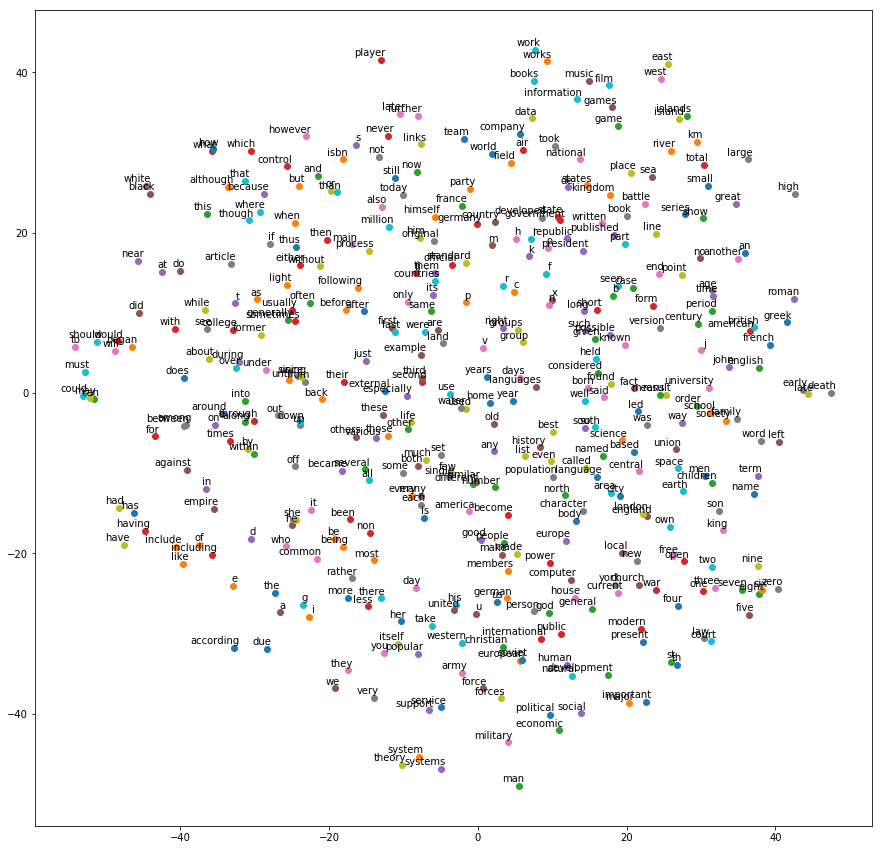

In [47]:
num_points = 400

tsne = TSNE(perplexity=30, n_components=2, init='pca', n_iter=5000, method='exact')
two_d_embeddings = tsne.fit_transform(final_embeddings[1:num_points+1, :])

def plot(embeddings, labels):
    assert embeddings.shape[0] >= len(labels), 'More labels than embeddings'
    pylab.figure(figsize=(15,15))  # in inches
    for i, label in enumerate(labels):
        x, y = embeddings[i,:]
        pylab.scatter(x, y)
        pylab.annotate(label, xy=(x, y), xytext=(5, 2), textcoords='offset points', ha='right', va='bottom')
    pylab.show()

words = [reverse_dictionary[i] for i in range(1, num_points+1)]
plot(two_d_embeddings, words)